Reference coverage: 100.0%, Citation coverage: 1.9%
Edge counts: {'reference': 1264, 'citation': 381, 'both': 7}


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\Galaxy\miniconda3\envs\litscape\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Galaxy\miniconda3\envs\litscape\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Galaxy\miniconda3\envs\litscape\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


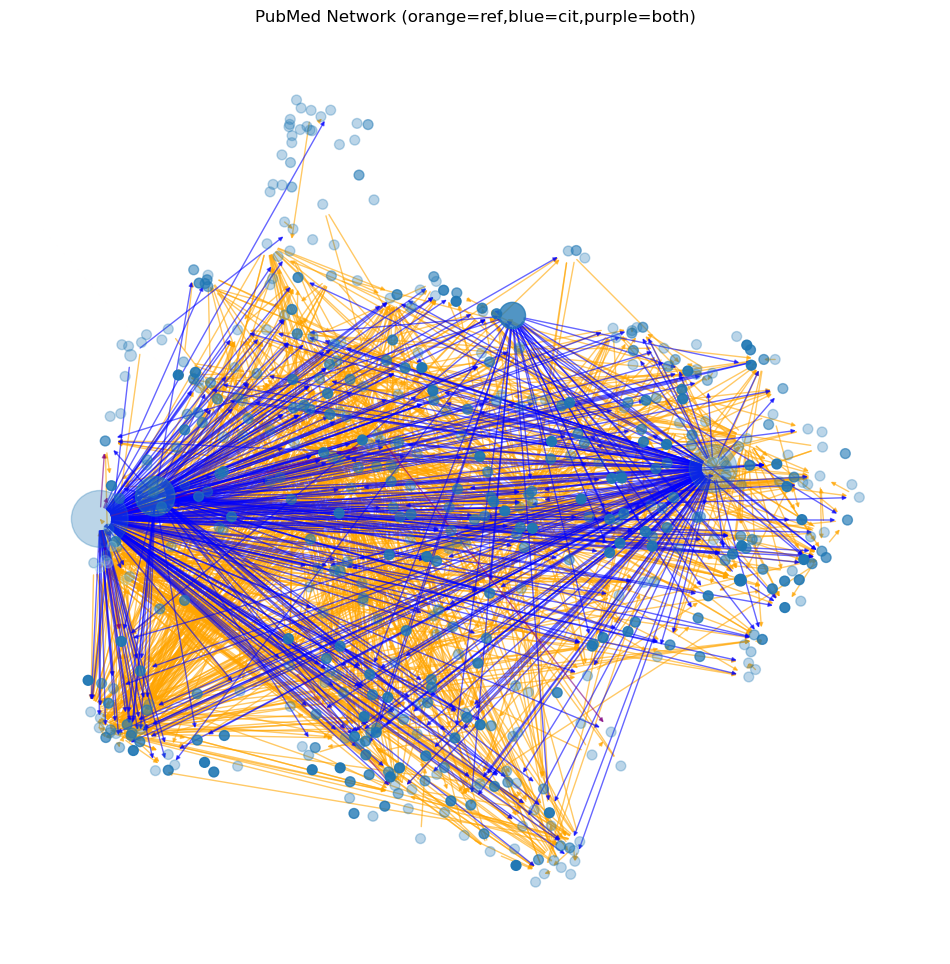

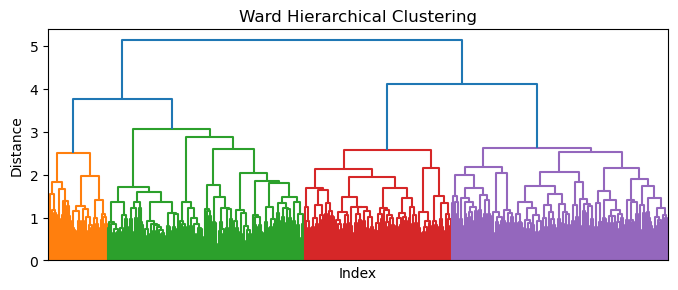

FloatSlider(value=0.977755109652907, description='Ward T:', max=5.12424434220631)

Output(layout=Layout(height='300px'))

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
pubmed_citation_network_full.py
Author: [Your Name]
Date: 2025-05-03

Description:
    Builds, styles, and visualizes a PubMed citation/reference network for a
    given query, with robust provenance tracking and interactive clustering.

Features:
  1. ESearch (history server) → PMIDs
  2. EFetch → title, abstract, reference lists, and EARLIEST publication date
     (ArticleDate preferred, fallback to JournalIssue/PubDate)
  3. ELink(pubmed_pubmed_citedin) in batches → citation lists
  4. Builds DiGraph:
       • Nodes carry title, abstract, date
       • Edges point cited → citing (information flow)
       • Edge attribute source_type ∈ {reference, citation, both}
       • Self-edges automatically dropped
  5. Coverage diagnostics:
       • % of all seen references present as nodes
       • % of all seen citers present as nodes
       • Edge counts by provenance
  6. Node attributes:
       • ext_citations = external citation count
       • alpha         = opacity based on age (newer → more opaque)
  7. Embeddings:
       • SBERT(all-MiniLM-L6-v2) on title+abstract (GPU if available)
       • UMAP → 2D coords for node positions
  8. Clustering:
       • DBSCAN on original embeddings → node “db_cluster”
       • Ward hierarchical clustering + dendrogram
       • ipywidgets slider to re-cut dendrogram and recolor nodes
  9. Styling:
       • Node size ∝ ext_citations
       • Node α = alpha
       • Edge color: orange=reference, blue=citation, purple=both
       • Arrows show information flow (cited → citing)
"""

import requests, time, xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime

# ---------------- Configuration ---------------- #

PUBMED_QUERY = "(metformin[tiab] OR glucophage[tiab]) AND (aging[mesh] OR longevity[mesh])"
MAX_RESULTS  = 1000
ELINK_BATCH  = 100

# ---------------- PubMed Utilities ---------------- #

def search_pubmed(query, retmax=MAX_RESULTS):
    """ESearch with history server → (pmids, WebEnv, QueryKey)."""
    resp = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
        params={"db":"pubmed","term":query,"retmax":retmax,"usehistory":"y"}
    )
    resp.raise_for_status()
    root = ET.fromstring(resp.content)
    pmids = [n.text for n in root.findall(".//IdList/Id")]
    return pmids, root.findtext(".//WebEnv"), root.findtext(".//QueryKey")

def fetch_details(pmids, webenv, qkey):
    """
    EFetch → list of dicts with
      pmid, title, abstract, refs (all in-set, no self-refs), date.
    """
    resp = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
        data={"db":"pubmed","retmode":"xml",
              "WebEnv":webenv,"query_key":qkey,"retmax":len(pmids)}
    )
    resp.raise_for_status()
    root = ET.fromstring(resp.content)
    MONTH = {m:i for i,m in enumerate(
        ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],1)}
    arts = []
    for art in root.findall(".//PubmedArticle"):
        pmid = art.findtext(".//PMID")
        title = art.findtext(".//ArticleTitle") or ""
        abstract = " ".join(n.text for n in art.findall(".//AbstractText") if n.text) or ""
        # parse earliest date
        date = None
        for ad in art.findall(".//ArticleDate"):
            if ad.get("DateType","").lower() in ("electronic","pubmed"):
                y,mo,dy = ad.findtext("Year"),ad.findtext("Month"),ad.findtext("Day")
                if y and y.isdigit():
                    date = datetime.date(int(y),
                        int(mo) if mo and mo.isdigit() else MONTH.get(mo[:3],1),
                        int(dy) if dy and dy.isdigit() else 1)
                    break
        if date is None:
            pj = art.find(".//JournalIssue/PubDate")
            y,mo,dy = pj.findtext("Year"),pj.findtext("Month"),pj.findtext("Day")
            if y and y.isdigit():
                date = datetime.date(int(y),
                    MONTH.get(mo[:3],1) if mo else 1,
                    int(dy) if dy and dy.isdigit() else 1)
        # references (in-set & no self)
        refs = []
        for r in art.findall(".//ReferenceList/Reference"):
            pid = r.findtext(".//ArticleId[@IdType='pubmed']")
            if pid and pid in pmids and pid!=pmid:
                refs.append(pid)
        arts.append({"pmid":pmid,"title":title,
                     "abstract":abstract,"refs":refs,"date":date})
    return arts

def fetch_citations(pmids, batch_size=ELINK_BATCH):
    """
    ELink(pubmed_pubmed_citedin) in batches → (citations_within, all_citers).
    citations_within: only those in pmids. all_citers: full set.
    """
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"
    cit_within = {p:[] for p in pmids}
    all_citers  = set()
    for i in range(0,len(pmids),batch_size):
        batch = pmids[i:i+batch_size]
        resp = requests.get(url, params={
            "dbfrom":"pubmed",
            "linkname":"pubmed_pubmed_citedin",
            "id":",".join(batch)
        })
        resp.raise_for_status()
        root = ET.fromstring(resp.content)
        for ls in root.findall(".//LinkSet"):
            src = ls.findtext(".//IdList/Id")
            for tgt in ls.findall(".//LinkSetDb/Link/Id"):
                all_citers.add(tgt.text)
                if tgt.text in pmids and tgt.text!=src:
                    cit_within[src].append(tgt.text)
        time.sleep(0.34)
    return cit_within, all_citers

# ---------------- Graph Construction ---------------- #

def build_graph(arts, cit_within):
    """
    Build DiGraph:
      • Nodes carry title, abstract, date.
      • Edges point cited→citing.
      • Edge attr source_type ∈ {reference,citation,both}.
    """
    G = nx.DiGraph()
    all_refs = set()
    # add nodes
    for a in arts:
        G.add_node(a["pmid"],
                   title=a["title"],
                   abstract=a["abstract"],
                   date=a["date"])
    # reference edges
    for a in arts:
        tgt = a["pmid"]
        for ref in a["refs"]:
            all_refs.add(ref)
            if G.has_edge(ref,tgt):
                G[ref][tgt]["source_type"]="both"
            else:
                G.add_edge(ref,tgt,source_type="reference")
    # citation edges
    for src,clist in cit_within.items():
        for citer in clist:
            if G.has_edge(src,citer):
                G[src][citer]["source_type"]="both"
            else:
                G.add_edge(src,citer,source_type="citation")
    return G, all_refs

def coverage(G, all_refs, all_citers):
    """Return ref_coverage, cit_coverage, edge_type_counts."""
    nodes = set(G.nodes)
    rcov = len(all_refs & nodes)/max(1,len(all_refs))
    ccov = len(all_citers & nodes)/max(1,len(all_citers))
    cnt = {"reference":0,"citation":0,"both":0}
    for _,_,d in G.edges(data=True):
        cnt[d["source_type"]] +=1
    return rcov, ccov, cnt

# ---------------- Embedding & Clustering ---------------- #

def embed_and_project(texts):
    """SBERT→embeddings (GPU if avail) + UMAP(2D)."""
    model = SentenceTransformer("all-MiniLM-L6-v2")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device=="cuda": model=model.to("cuda")
    E = model.encode(texts,show_progress_bar=True,device=device)
    coords = UMAP(n_components=2,random_state=42).fit_transform(E)
    return E, coords

# ---------------- Main Execution ---------------- #

# 1. Fetch
pmids, we, qk             = search_pubmed(PUBMED_QUERY)
articles                 = fetch_details(pmids, we, qk)
citations_within, all_citers = fetch_citations(pmids)

# 2. Build graph + diagnostics
G, all_refs = build_graph(articles, citations_within)
rcov, ccov, ecounts = coverage(G, all_refs, all_citers)
print(f"Reference coverage: {rcov:.1%}, Citation coverage: {ccov:.1%}")
print("Edge counts:", ecounts)

# 3. Annotate nodes (ext_cits, alpha)
today = datetime.date.today()
for n in G.nodes:
    ext = len(citations_within.get(n,[]))
    G.nodes[n]['ext_cits']=ext
    d = G.nodes[n]['date']
    alpha = 0.5
    if d:
        yrs = (today-d).days/365.25
        alpha = max(0.3,min(1,1-yrs/10))
    G.nodes[n]['alpha']=alpha

# 4. Position & cluster
texts = [a["title"]+" "+a["abstract"] for a in articles]
E, coords = embed_and_project(texts)
pos = {a["pmid"]:coords[i] for i,a in enumerate(articles)}
db_labels = DBSCAN(eps=0.5,min_samples=5).fit_predict(E)
Z = linkage(E, method='ward')

# 5. Draw network
plt.figure(figsize=(12,12))
# nodes
nx.draw_networkx_nodes(G,pos,
    node_size=[50+10*G.nodes[n]['ext_cits'] for n in G],
    alpha=[G.nodes[n]['alpha'] for n in G],
    node_color=db_labels, cmap='tab20'
)
# edges
color_map = {"reference":"orange","citation":"blue","both":"purple"}
for stype,col in color_map.items():
    eds=[(u,v) for u,v,d in G.edges(data=True) if d["source_type"]==stype]
    nx.draw_networkx_edges(G,pos,edgelist=eds,edge_color=col,alpha=0.6,arrowstyle='-|>',arrowsize=6)
plt.title("PubMed Network (orange=ref,blue=cit,purple=both)")
plt.axis('off')
plt.show()

# 6. Dendrogram + interactive Ward cut
plt.figure(figsize=(8,3))
dendrogram(Z,no_labels=True)
plt.title("Ward Hierarchical Clustering")
plt.xlabel("Index"); plt.ylabel("Distance")
plt.show()

slider = widgets.FloatSlider(min=0,max=Z[:,2].max(),step=0.1,value=Z[:,2].mean(),
    description="Ward T:")
out = widgets.Output(layout={'height':'300px','overflow_y':'scroll'})
def on_val_change(change):
    with out:
        clear_output()
        labs = fcluster(Z,t=change['new'],criterion='distance')
        plt.figure(figsize=(8,8))
        nx.draw_networkx_nodes(G,pos,
            node_size=[50+10*G.nodes[n]['ext_cits'] for n in G],
            alpha=[G.nodes[n]['alpha'] for n in G],
            node_color=labs, cmap='tab20'
        )
        nx.draw_networkx_edges(G,pos,alpha=0.3)
        plt.axis('off'); plt.show()
slider.observe(on_val_change,'value')
display(slider,out)


In [ ]:
# =============================================================================
# CELL: DAG Checker with Corrected Edge Directionality & Provenance
# =============================================================================
# For each query in QUERIES, this cell:
#   1. ESearch → PMIDs
#   2. EFetch → publication dates & reference lists
#   3. ELink  → citation lists
#   4. Select top SUBSET_N by total refs+cit
#   5. Build DiGraph:
#        • reference edges: B → A  if A references B
#        • citation edges: C → D  if D cites C
#        • provenance ∈ {reference,citation,both}
#   6. Report initial graph size
#   7. Identify all time‐invalid edges (u→v where date[u] > date[v])
#        • Record source, src_date, target, tgt_date, provenance
#   8. Display scrollable violations table
#   9. Remove only the invalid edges (not nodes)
#  10. Report cleaned graph size and DAG status
#
# Paste into Jupyter after defining QUERIES, SEARCH_MAX, SUBSET_N, ELINK_BATCH.
# =============================================================================

import requests, time, xml.etree.ElementTree as ET
import pandas as pd, networkx as nx, datetime
import ipywidgets as widgets
from IPython.display import display

# --- Configuration ---
QUERIES     = [
    "neoplasm metastasis[mesh] AND immunotherapy[mesh]",
    "COVID-19[mesh] AND spike glycoprotein[mesh]",
    "cardiomyopathies[mesh] AND cardiac MRI[mesh]",
    "Alzheimer disease[mesh] AND neurofilament proteins[mesh]",
    "radiology[mesh] AND deep learning[tiab] AND segmentation[tiab]",
    "CRISPR-Cas systems[mesh] AND gene knockout[mesh]"
]
SEARCH_MAX  = 1000
SUBSET_N    = 200
ELINK_BATCH = 100

# --- Helper Functions ---

def search_pubmed(q, retmax=SEARCH_MAX):
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
        params={"db":"pubmed","term":q,"retmax":retmax,"usehistory":"y"}
    ); r.raise_for_status()
    t = ET.fromstring(r.content)
    return [n.text for n in t.findall(".//IdList/Id")], t.findtext(".//WebEnv"), t.findtext(".//QueryKey")

def fetch_dates_refs(pmids, we, qk):
    r = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
        data={"db":"pubmed","retmode":"xml","WebEnv":we,"query_key":qk,"retmax":len(pmids)}
    ); r.raise_for_status()
    t = ET.fromstring(r.content)
    MONTH = {m:i for i,m in enumerate(
        ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],1)}
    rows = []
    for art in t.findall(".//PubmedArticle"):
        pm = art.findtext(".//PMID")
        # extract earliest date
        dt = None
        for ad in art.findall(".//ArticleDate"):
            y,mo,d = ad.findtext("Year"),ad.findtext("Month"),ad.findtext("Day")
            if y and y.isdigit():
                dt = datetime.date(int(y),
                                   int(mo) if mo and mo.isdigit() else MONTH.get(mo[:3],1),
                                   int(d) if d and d.isdigit() else 1)
                break
        if dt is None:
            pj = art.find(".//JournalIssue/PubDate")
            y,mo,d = pj.findtext("Year"),pj.findtext("Month"),pj.findtext("Day")
            if y and y.isdigit():
                dt = datetime.date(int(y),
                                   MONTH.get(mo[:3],1) if mo else 1,
                                   int(d) if d and d.isdigit() else 1)
        # references
        refs = [r.findtext(".//ArticleId[@IdType='pubmed']")
                for r in art.findall(".//ReferenceList/Reference")]
        refs = [x for x in refs if x in pmids and x!=pm]
        rows.append({"pmid":pm,"date":dt,"refs":refs})
    return pd.DataFrame(rows)

def fetch_citations(pmids, batch_size=ELINK_BATCH):
    """
    Fetches citation data (papers citing the PMIDs in the list) using ELink.
    Includes specific debugging for the 33215849 -> 32634865 issue.
    """
    cit = {p: [] for p in pmids}
    # --- DEBUG: Define the specific PMIDs we are tracking ---
    SOURCE_PMID_DEBUG = '33215849'
    TARGET_PMID_DEBUG = '32634865'
    # --- END DEBUG ---

    print(f"*** fetch_citations: Looking for potential edge {SOURCE_PMID_DEBUG} -> {TARGET_PMID_DEBUG}")

    for i in range(0, len(pmids), batch_size):
        bx = pmids[i:i + batch_size]
        is_source_in_batch = SOURCE_PMID_DEBUG in bx
        is_target_in_batch = TARGET_PMID_DEBUG in bx # Track if target is also requested

        if is_source_in_batch:
            print(f"\n--- DEBUG: Batch starting index {i} CONTAINS the SOURCE PMID {SOURCE_PMID_DEBUG} ---")
            print(f"--- Batch IDs (first 10): {bx[:10]}... ({len(bx)} total)")

        # Make the ELink request
        try:
            r = requests.get(
                "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                params={"dbfrom": "pubmed", "linkname": "pubmed_pubmed_citedin", "id": ",".join(bx)}
            )
            r.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"*** ERROR: HTTP Request failed for batch starting at index {i}: {e}")
            time.sleep(0.34) # Still sleep on error before continuing
            continue # Skip this batch

        # --- DEBUG: Print RAW XML only for the batch containing the source ---
        if is_source_in_batch:
            print(f"\n--- RAW XML Response for Batch Containing {SOURCE_PMID_DEBUG} (Snippet) ---")
            # Limit printing if it's still too large
            xml_content = r.text
            start_index = xml_content.find(f"<Id>{SOURCE_PMID_DEBUG}</Id>")
            context_chars = 1000 # Show characters around the source ID
            start = max(0, start_index - context_chars)
            end = start_index + context_chars
            print(f"... (showing snippet around {SOURCE_PMID_DEBUG}) ...")
            print(xml_content[start:end])
            print(f"... (end snippet) ...")
            # Optionally, save the full XML to a file for inspection
            # with open(f"elink_batch_{i}_containing_{SOURCE_PMID_DEBUG}.xml", "w") as f:
            #     f.write(xml_content)
            # print(f"--- Full XML saved to elink_batch_{i}_containing_{SOURCE_PMID_DEBUG}.xml ---")
            print(f"--- END RAW XML Snippet ---")

        # Parse the XML
        try:
            # Check for empty content *before* parsing
            if not r.content:
                if is_source_in_batch:
                     print(f"*** WARNING: Received EMPTY response for batch containing {SOURCE_PMID_DEBUG}.")
                continue # Skip empty response

            t = ET.fromstring(r.content)

        except ET.ParseError as e:
            print(f"*** ERROR: XML Parse Error for batch starting index {i}: {e}")
            if is_source_in_batch:
                print("--- Faulty XML Snippet (from batch with source) ---")
                print(r.text[:1000]) # Print beginning of faulty XML
                print("--- End Snippet ---")
            continue # Skip this batch

        # Process the parsed XML
        linksets_processed_for_source = False
        for ls in t.findall(".//LinkSet"):
            # Get the source ID(s) for this specific LinkSet
            # ELink can sometimes return multiple source IDs if they are merged,
            # but usually it's one per LinkSet for this type of query.
            linkset_source_ids = [id_node.text for id_node in ls.findall(".//IdList/Id")]
            if not linkset_source_ids:
                continue # Should not happen, but good practice

            # We primarily care about the first source ID matching our batch request logic
            current_src = linkset_source_ids[0]

            # Check if this LinkSet is for our specific source of interest
            if current_src == SOURCE_PMID_DEBUG:
                linksets_processed_for_source = True
                print(f"\n--- DEBUG: Processing LinkSet explicitly for SOURCE {SOURCE_PMID_DEBUG} ---")
                found_target_in_this_linkset = False

                link_set_db = ls.find(".//LinkSetDb")
                if link_set_db is not None:
                    targets_in_linkset = [] # Collect all targets found for *this specific LinkSet*
                    for tgt_element in link_set_db.findall(".//Link/Id"):
                        current_tgt = tgt_element.text
                        targets_in_linkset.append(current_tgt) # Add to list for this LinkSet

                        # Is this the problematic target we are looking for?
                        if current_tgt == TARGET_PMID_DEBUG:
                            found_target_in_this_linkset = True
                            print(f"  >>> FOUND Target {TARGET_PMID_DEBUG} within LinkSet for Source {SOURCE_PMID_DEBUG}!")

                        # Now, perform the logic to add to the main 'cit' dictionary
                        # Check if target is one of the PMIDs we care about (in the initial full list)
                        # and it's not the same as the source
                        if current_tgt in cit and current_tgt != current_src:
                            # Ensure source is a valid key before appending
                            if current_src in cit:
                                cit[current_src].append(current_tgt)
                                # **** THE CRITICAL CHECK ****
                                if current_src == SOURCE_PMID_DEBUG and current_tgt == TARGET_PMID_DEBUG:
                                    print(f"  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                                    print(f"  !!! CRITICAL: Appending {current_tgt} to cit['{current_src}']")
                                    print(f"  !!! This link WILL cause the violation if dates mismatch.")
                                    print(f"  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                            # else: # This case indicates a potential logic issue upstream or unexpected API response
                            #     print(f"*** WARNING: Source {current_src} from LinkSet not found in initial cit dictionary keys.")
                        # elif current_src == SOURCE_PMID_DEBUG and current_tgt == TARGET_PMID_DEBUG:
                        #      print(f"  *** Target {TARGET_PMID_DEBUG} for source {SOURCE_PMID_DEBUG} was found in XML but SKIPPED (target==source or target not in initial PMID list)")

                    print(f"  --- Targets found in this LinkSet for {SOURCE_PMID_DEBUG}: {targets_in_linkset[:10]}... ({len(targets_in_linkset)} total)")
                else:
                    print(f"  --- No <LinkSetDb> found within LinkSet for {SOURCE_PMID_DEBUG}")

                if not found_target_in_this_linkset:
                    print(f"  --- Target {TARGET_PMID_DEBUG} was NOT found within this specific LinkSet for Source {SOURCE_PMID_DEBUG}.")
            # --- End of processing block for specific source ---

            # --- Original logic to populate cit for *other* sources in the batch ---
            # --- This is needed for the script to function, but we are not debugging these ---
            elif current_src in cit: # Process other sources normally
                 link_set_db = ls.find(".//LinkSetDb")
                 if link_set_db is not None:
                      for tgt_element in link_set_db.findall(".//Link/Id"):
                           current_tgt = tgt_element.text
                           if current_tgt in cit and current_tgt != current_src:
                                cit[current_src].append(current_tgt)
            # --- End original logic block ---

        if is_source_in_batch and not linksets_processed_for_source:
             print(f"\n--- WARNING: Source PMID {SOURCE_PMID_DEBUG} was in the batch request, but no corresponding <LinkSet> was found or processed in the response XML.")


        # NCBI rate limiting
        time.sleep(0.34)

    print(f"*** fetch_citations finished. Checking cit dictionary for {SOURCE_PMID_DEBUG}:")
    if SOURCE_PMID_DEBUG in cit:
        if TARGET_PMID_DEBUG in cit[SOURCE_PMID_DEBUG]:
            print(f"  >>> CONFIRMED: {TARGET_PMID_DEBUG} IS present in cit['{SOURCE_PMID_DEBUG}'] list after processing all batches.")
        else:
            print(f"  --- OK: {TARGET_PMID_DEBUG} is NOT present in cit['{SOURCE_PMID_DEBUG}'] list after processing all batches.")
    else:
        print(f"  --- Source {SOURCE_PMID_DEBUG} not found as a key in the final cit dictionary (perhaps filtered out before ELink?).")

    return cit

# --- Analysis Routine ---

def analyze_dag_edges(query):
    print(f"\n=== Query: {query} ===")
    pmids, we, qk = search_pubmed(query)
    print(f"1) Retrieved {len(pmids)} PMIDs")
    
    df = fetch_dates_refs(pmids, we, qk)
    cit = fetch_citations(pmids)
    df["ref_count"] = df["refs"].str.len()
    df["cit_count"] = df["pmid"].map(lambda p: len(cit[p]))
    df["total"]    = df["ref_count"] + df["cit_count"]
    df_top = df.nlargest(SUBSET_N, "total").reset_index(drop=True)

    print(f"2) Top {SUBSET_N} articles by total:")
    out1 = widgets.Output(layout={'height':'200px','overflow_y':'scroll'})
    with out1:
        display(df_top[['pmid','date','ref_count','cit_count','total']])
    display(out1)

    # Build graph with corrected directionality
    G = nx.DiGraph()
    for _,r in df_top.iterrows():
        G.add_node(r["pmid"], date=r["date"])
    for _,r in df_top.iterrows():
        art = r["pmid"]
        # references: B -> A
        for b in r["refs"]:
            if b in G:
                G.add_edge(b, art, provenance="reference")
        # citations: C -> D where D cites C
        for d in cit[art]:
            if d in G:
                if G.has_edge(art, d):
                    G[art][d]["provenance"] = "both"
                else:
                    G.add_edge(art, d, provenance="citation")
    print(f"3) Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Identify time-invalid edges (u->v where date[u] > date[v])
    viols = []
    for u,v,d in G.edges(data=True):
        du, dv = G.nodes[u]["date"], G.nodes[v]["date"]
        if du and dv and du > dv:
            viols.append({
                "source": u, "src_date": du,
                "target": v, "tgt_date": dv,
                "provenance": d["provenance"]
            })
    df_viol = pd.DataFrame(viols)
    if not df_viol.empty:
        print(f"4) Found {len(df_viol)} time‐invalid edges:")
        out2 = widgets.Output(layout={'height':'200px','overflow_y':'scroll'})
        with out2:
            display(df_viol.head(10))
        display(out2)

        # Aggregate violations by edge provenance and by source
        df_off = (df_viol
                  .groupby(["source","src_date","provenance"])
                  .size()
                  .reset_index(name="violation_count")
                  .sort_values("violation_count", ascending=False))
        print("   Violations summary (by source & provenance):")
        out3 = widgets.Output(layout={'height':'200px','overflow_y':'scroll'})
        with out3:
            display(df_off.head(10))
        display(out3)

        # Remove only invalid edges
        for row in viols:
            G.remove_edge(row["source"], row["target"])
        print(f"   Removed {len(viols)} invalid edges.")
    else:
        print("4) No time‐invalid edges detected.")

    # Final DAG check
    is_dag = nx.is_directed_acyclic_graph(G)
    print(f"5) Final DAG status: {'✅ DAG' if is_dag else '❌ cycles remain'}\n")

# Execute for all queries
for q in QUERIES:
    analyze_dag_edges(q)
